# Facial Recognition - Training Notebook

**Introduction:**<br>
- This notebook contains our training of our facial recognition model. It also contains a benchmarking of the model performance.
- For runtime reasons this notebook was run on Google Colab.
- We train the Keras implementation of OpenFace with a transfer learning approach by freezing the pretrained weights, removing the last layer of the pretrained model and adding our own dense layer to be trained. It has 128 neurons representing the size of the embedding vector.
- Before the actual training we build an online triplet loss generator, that selects a mix of hard triplets and random triplets in the training batches.
- During the training we use a siamese model taking as an input a triplet and output a vector of lenght 3xEmbedding_size=384. For this output layer we can then compute the triplet loss to adapt the weights backpropagating through the network.

**Notebook Contents:**
1. [Setup Google Colab](#1.-Setup-Google-Colab)
2. [Import Requirements](#2.-Import-Requirements)
3. [Data Preparation](#3.-Data-Preparation)
4. [Build Siamese Model with Triplet Loss](#4.-Build-Siamese-Model-with-Triplet-Loss)
5. [Batch Generation](#5.-Batch-Generation)
6. [Evaluation before Training](#6.-Evaluation-before-Training)
7. [Training](#7.-Training)
8. [Evaluation after Training](#8.-Evaluation-after-Training)
9. [Save Model](#9.-Save-Model)
10. [Benchmarking](#10.-Benchmarking)

**References:**
- [Transfer Learning](https://medium.com/@p.rajeshbabu6666/face-recognition-using-transfer-learning-64de34de68a6)
- [Triplet Loss](https://www.tensorflow.org/addons/tutorials/losses_triplet)
- [Online Triplet Mining](https://omoindrot.github.io/triplet-loss#a-naive-implementation-of-triplet-loss)
- [Siamese Networks](https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352)

<br>

## 1. Setup Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

import os 

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "CVFinalFolder"

def create_and_set_working_directory(project_folder):
    # check if your project folder exists. if not, it will be created.
    if os.path.isdir(root_dir + project_folder) == False:
        os.mkdir(root_dir + project_folder)
        print(root_dir + project_folder + ' did not exist but was created.')

    # change the OS to use your project folder as the working directory
    os.chdir(root_dir + project_folder)

    # create a test file to make sure it shows up in the right place
    !touch 'new_file_in_working_directory.txt'
    print('\nYour working directory was changed to ' + root_dir + project_folder + \
          "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/CVFinalFolder

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [3]:
!pwd

/content/drive/My Drive/CVFinalFolder


## 2. Import Requirements

In [6]:
!pip install -r requirements.txt

     |████████████████████████████████| 320.4MB 53kB/s 
     |████████████████████████████████| 2.3MB 16.4MB/s 
     |████████████████████████████████| 245kB 50.3MB/s 
     |████████████████████████████████| 100.2MB 32kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=ca93974cf53c17e64e44eccd74ae517b9a00450c314245a0cc9e7e2e5c6c9c91
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from collections import Counter 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve,roc_auc_score

import tensorflow as tf
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras.utils import plot_model, normalize
from keras import backend as K

from pylab import *

from facial_recognition import data_creation
from facial_recognition import data_preprocessing
from facial_recognition.models.openface_model import model

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.1


## 3. Data-Preparation

In [16]:
### LOAD DATA INTO NOTEBOOK ###

# Load example dataset
data_lfwcrop = data_creation.load_data_lfwcrop('facial_recognition/data/lfwcrop_grey/faces')
print('data_lfwcrop loaded')
data_uficrop = data_creation.load_data_uficrop('facial_recognition/data')
print('data_uficrop loaded')
data_FacePix = data_creation.load_data_FacePix('facial_recognition/data')
print('data_FacePix loaded')
data_facerec = data_creation.merge_data([data_lfwcrop, data_uficrop, data_FacePix])
print(f'Dataset facerec created: {sum([sum([len(li) for li in val]) for val in data_facerec.values()])} images of {len(data_facerec)} different individuals.')

Progress: 9.62962962962963 %
Progress: 19.25925925925926 %
Progress: 28.88888888888889 %
Progress: 38.51851851851852 %
Progress: 48.148148148148145 %
Progress: 57.77777777777778 %
Progress: 67.4074074074074 %
Progress: 77.03703703703704 %
Progress: 86.66666666666667 %
Progress: 96.29629629629629 %
data_lfwcrop loaded
Progress: 10.0 %
Progress: 20.0 %
Progress: 30.0 %
Progress: 40.0 %
Progress: 50.0 %
Progress: 60.0 %
Progress: 70.0 %
Progress: 80.0 %
Progress: 90.0 %
data_uficrop loaded
Progress: 13.333333333333334 %
Progress: 26.666666666666668 %
Progress: 40.0 %
Progress: 53.333333333333336 %
Progress: 66.66666666666667 %
Progress: 80.0 %
Progress: 93.33333333333333 %
data_FacePix loaded
Dataset facerec created: 19054 images of 6341 different individuals.


In [17]:
### DATA PREPROCESSING ###

# Several preprocessing operations
images, labels = data_preprocessing.dict_to_model_input(data_facerec, 
                                                   grey2rgb=True, 
                                                   normalize=True, 
                                                   alignment=True, 
                                                   new_size=(96, 96))

print(f'X type: {type(images)}, X shape: {images.shape}')
print(f'labels type: {type(labels)}, labels length: {len(labels)}')

Progress: 5.080298100136455 %
Progress: 10.16059620027291 %
Progress: 15.240894300409362 %
Progress: 20.32119240054582 %
Progress: 25.40149050068227 %
Progress: 30.481788600818724 %
Progress: 35.56208670095518 %
Progress: 40.64238480109164 %
Progress: 45.72268290122809 %
Progress: 50.80298100136454 %
Progress: 55.883279101500996 %
Progress: 60.96357720163745 %
Progress: 66.04387530177391 %
Progress: 71.12417340191035 %
Progress: 76.20447150204681 %
Progress: 81.28476960218327 %
Progress: 86.36506770231972 %
Progress: 91.44536580245618 %
Progress: 96.52566390259263 %
X type: <class 'numpy.ndarray'>, X shape: (19054, 96, 96, 3)
labels type: <class 'list'>, labels length: 19054


In [38]:
### REMOVE ALL LABELS THAT APPEAR LESS OFTEN THAN A THRESHOLD ###
# This makes triplet mining easier

# Removes all elements that appear less often than k
def removeElements(labels, k): 
    counted = Counter(labels)
    new_labels = [el for el in labels if counted[el] >= k]
    indices = [idx for idx, el in enumerate(labels) if counted[el] >= k] 
    return new_labels, indices

# Get remaining labels and corresponding images
y, indices = removeElements(labels, 12)
X = images[indices,:,:,:]

# Encode lables
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

print(f'There are {len(y)} images of {len(set(y))} different individuals left.')
print(X.shape, y.shape)

There are 5215 images of 172 different individuals left.
(5215, 96, 96, 3) (5215,)


In [49]:
### TRAIN-TEST-SPLIT ###

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=256)

print(f'x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}')
print(f'x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}')
print(f'The number of labels are {len(np.unique(y))} (training: {len(np.unique(y_train))}, testing: {len(np.unique(y_test))}).')

x_train.shape: (3911, 96, 96, 3), y_train.shape: (3911,)
x_test.shape: (1304, 96, 96, 3), y_test.shape: (1304,)
The number of labels are 172 (training: 172, testing: 172).


In [50]:
### FORMAT DATASET ###

nb_classes = len(np.unique(y))
img_rows, img_cols = 96, 96
input_shape = (img_rows, img_cols, 3)

def buildDataSet(x_train_origin, x_test_origin, y_train_origin, y_test_origin):
    """Build dataset for train and test

    returns: dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """

    assert K.image_data_format() == 'channels_last'
    x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 3)
    x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 3)
    
    dataset_train = []
    dataset_test = []
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        dataset_train.append(images_class_n)#/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n)#/255)
        
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin

In [51]:
# Function to show pictures from dataset
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,0],vmin=0, vmax=1,cmap='gray')
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))

In [52]:
### FINALIZE DATASET ###

dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin = buildDataSet(x_train, x_test, y_train, y_test)

Checking shapes for class 0 (train) :  (20, 96, 96, 3)
Checking shapes for class 0 (test) :  (10, 96, 96, 3)
Checking first samples:


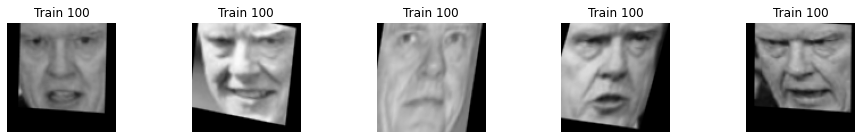

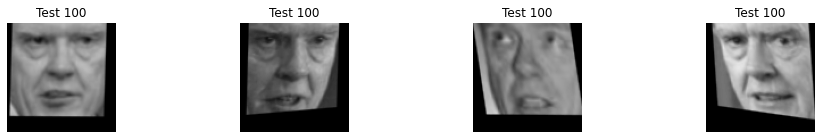

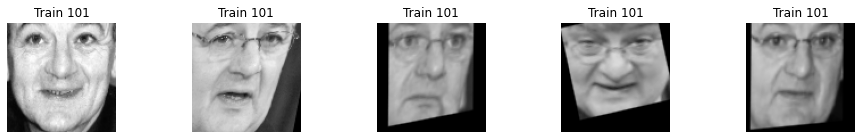

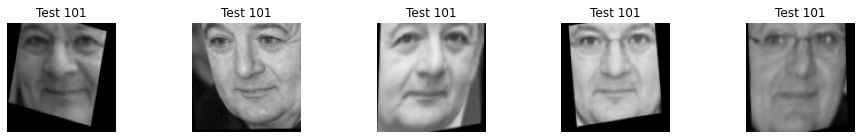

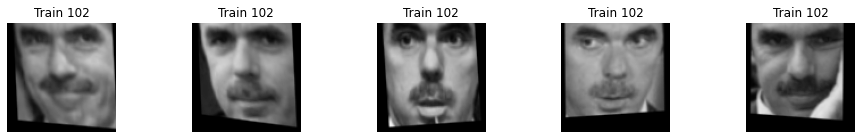

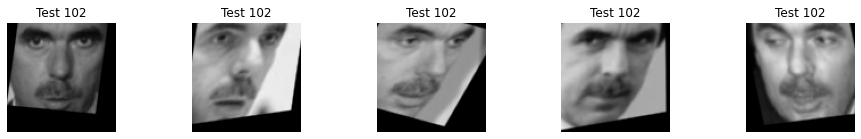

In [54]:
# Check a sample
sample_idx = 0
print("Checking shapes for class 0 (train) : ",dataset_train[sample_idx].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[sample_idx].shape)

# Show first samples
print("Checking first samples:")
for i in range(100,103):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)

## 4. Build Siamese Model with Triplet Loss

In [140]:
### INITIALIZE TRANSFER LEARNING FOR OPENFACE MODEL ###

def build_network(input_shape):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
    # Embedding Model
    from facial_recognition.models.openface_model import model

    # Load model weights
    model.load_weights('facial_recognition/models/openface_weights.h5')     # <--- Pretrained weights
    model.trainable = False                                                 # <--- Freeze weights
    
    # Transfer learning layers   # <--- Cut off last layer and add own trainable layers to network (embedding-size = 128)
    dense_layer2 = Dense(128, name='dense_layer2')(model.layers[-2].output)     
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer2)
    network = Model(model.input, norm_layer)
    return network

In [141]:
### CREATE TRIPLET LOSS ###

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [142]:
### SIAMESE MODEL ###

def build_model(input_shape, network, margin=0.2): # Siamese Network
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

In [143]:
### CREATE AND SUMMARIZE MODEL ###

network = build_network(input_shape)
network_train = build_model(input_shape,network)
optimizer = Adam(lr = 0.00006)
network_train.compile(loss=None,optimizer=optimizer)
network_train.summary()
print(network_train.metrics_names)

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
functional_15 (Functional)      (None, 128)          3759792     anchor_input[0][0]               
                                                                 positive_input[0][0] 

In [144]:
# Only our own last two layers are trainable
for (i, layer) in enumerate(network.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Lambda False
8 Conv2D False
9 BatchNormalization False
10 Activation False
11 ZeroPadding2D False
12 Conv2D False
13 BatchNormalization False
14 Activation False
15 ZeroPadding2D False
16 MaxPooling2D False
17 Conv2D False
18 Conv2D False
19 BatchNormalization False
20 BatchNormalization False
21 Activation False
22 Activation False
23 MaxPooling2D False
24 ZeroPadding2D False
25 ZeroPadding2D False
26 Conv2D False
27 Conv2D False
28 Conv2D False
29 BatchNormalization False
30 Conv2D False
31 BatchNormalization False
32 BatchNormalization False
33 Activation False
34 BatchNormalization False
35 Activation False
36 Activation False
37 ZeroPadding2D False
38 Activation False
39 Concatenate False
40 Lambda False
41 Conv2D False
42 Conv2D False
43 AveragePooling2D False
44 BatchNormalization False
45 BatchNormalization False
46 Lambda False
47 A

In [145]:
# testing our NN with dummy image
featured_img = network.predict(np.ones((1,img_rows,img_cols,3)))
print(featured_img)

[[-0.05528091 -0.22249813  0.02375089  0.01866575 -0.00907963 -0.10850537
   0.12426519 -0.02310846 -0.07082284  0.11383184 -0.07675783 -0.009447
  -0.13844568  0.01420344 -0.19683644 -0.06334214  0.23052676  0.09198424
   0.02329706  0.10053274  0.07264451  0.02367744  0.13397554 -0.08038703
  -0.11974206  0.0362051   0.02355737 -0.03488646 -0.17636156 -0.1028517
   0.08638945 -0.10042163 -0.2611554   0.04793078  0.1305488   0.07050394
   0.0950027   0.00739445  0.11274043  0.06187056 -0.1221989   0.08734132
   0.05859146  0.06303041  0.05953043  0.01618319 -0.00504303 -0.04134468
  -0.06084307  0.0103      0.00146193  0.02685545 -0.01546357 -0.01838501
   0.02784607  0.04761294  0.00887164 -0.03335338 -0.16170396  0.0939833
  -0.0890615   0.04944697  0.05439339 -0.00173395  0.02317677  0.03080627
   0.16406724 -0.07262935 -0.02444489  0.11216453  0.01399968 -0.07587003
   0.03610132 -0.04046854 -0.07575542  0.08993859 -0.03910825  0.05119866
  -0.03745492 -0.00884583 -0.04865867 -0.1

## 5. Batch Generation

In [146]:
### RANDOM BATCH GENERATION ###

def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[1].shape
    
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, nb_classes)
        nb_sample_available_for_class_AP = X[anchor_class].shape[0]
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        triplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]

    return triplets

def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='gray')
            subplot.title.set_text(labels[i])

In [147]:
### HARD-TRIPLET GENERATION ###

def compute_dist(a,b):
    return np.sum(np.square(a-b))

def get_batch_hard(draw_batch_size,hard_batchs_size,norm_batchs_size,network,s="train"):
    """
    Create batch of APN "hard" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[1].shape
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_random(draw_batch_size,s)
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    P = network.predict(studybatch[1])
    N = network.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the 
    selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = [studybatch[0][selection,:,:,:], studybatch[1][selection,:,:,:], studybatch[2][selection,:,:,:]]
    
    return triplets

Checking batch width, should be 3 :  3
Shapes in the batch A:(2, 96, 96, 3) P:(2, 96, 96, 3) N:(2, 96, 96, 3)


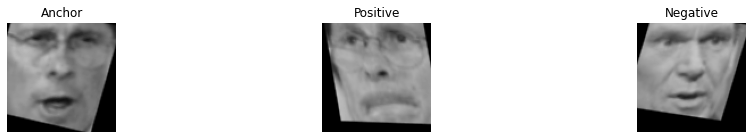

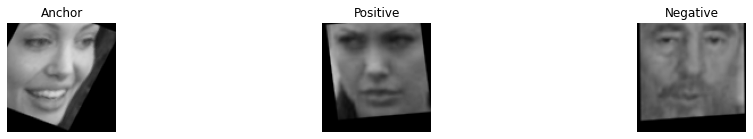

In [148]:
### TEST RANDOM BATCH GENERATION ###
# random might lead to easy triplets which is not good for learning

triplets = get_batch_random(2)
print("Checking batch width, should be 3 : ",len(triplets))
print("Shapes in the batch A:{0} P:{1} N:{2}".format(triplets[0].shape, triplets[1].shape, triplets[2].shape))
drawTriplets(triplets)

Shapes in the hardbatch A:(2, 96, 96, 3) P:(2, 96, 96, 3) N:(2, 96, 96, 3)


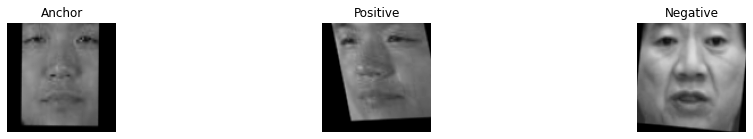

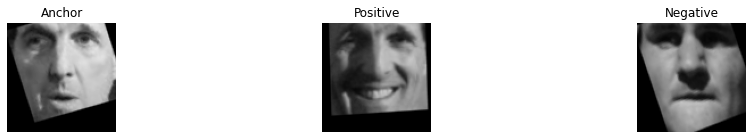

In [157]:
### TEST HARD BATCH GENERATION ###
# hard triplets are good for learning

hardtriplets = get_batch_hard(50,2,0,network) # one hard and one random sample
print("Shapes in the hardbatch A:{0} P:{1} N:{2}".format(hardtriplets[0].shape, hardtriplets[1].shape, hardtriplets[2].shape))
drawTriplets(hardtriplets)

## 6. Evaluation before Training

In [158]:
### EVALUATION FUNCTIONS ###

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,img_rows,img_cols,3))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

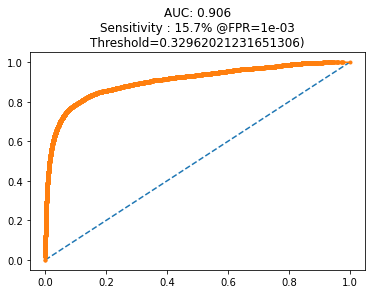

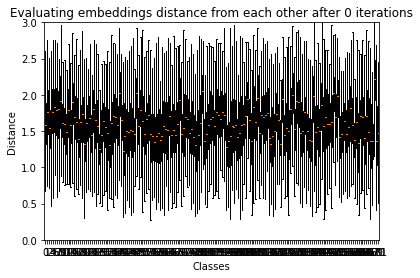

In [159]:
### TESTING ON THE UNTRAINED NETWORK ###

probs,yprob = compute_probs(network,x_test_origin[:500,:,:,:],y_test_origin[:500])
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
n_iteration=0
draw_interdist(network,n_iteration)

## 7. Training

In [160]:
### MODEL TRAINING ###

# Set hyper-parameters
evaluate_every = 250 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 5000 # No. of training iterations
n_val = 500 # how many one-shot tasks to validate on
best_loss = 1000000
losses = []

def create_checkpoint(network):
    # serialize weights to h5
    t = str(int(time.time()))
    network.save_weights("facial_recognition/weights"+t+".h5")
    return None

In [161]:
# Training Process
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
for i in range(1, n_iter+1):
    triplets = get_batch_hard(200,16,16,network)
    loss = network_train.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,n_iteration))
        probs,yprob = compute_probs(network,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr,thresholds)
        losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            checkpoint = create_checkpoint(network)

Starting training process!
-------------------------------------

 ------------- 

[250] Time for 250 iterations: 2.3 mins, Train Loss: 5.263474464416504

 ------------- 

[500] Time for 500 iterations: 4.5 mins, Train Loss: 1.6502337455749512

 ------------- 

[750] Time for 750 iterations: 6.7 mins, Train Loss: 3.484847068786621

 ------------- 

[1000] Time for 1000 iterations: 8.9 mins, Train Loss: 1.4851453304290771

 ------------- 

[1250] Time for 1250 iterations: 11.1 mins, Train Loss: 2.6662981510162354

 ------------- 

[1500] Time for 1500 iterations: 13.3 mins, Train Loss: 2.432065963745117

 ------------- 

[1750] Time for 1750 iterations: 15.5 mins, Train Loss: 2.6228246688842773

 ------------- 

[2000] Time for 2000 iterations: 17.6 mins, Train Loss: 3.0721747875213623

 ------------- 

[2250] Time for 2250 iterations: 19.8 mins, Train Loss: 4.537947654724121

 ------------- 

[2500] Time for 2500 iterations: 22.0 mins, Train Loss: 1.3828887939453125

 ------------- 

[

## 8. Evaluation after Training

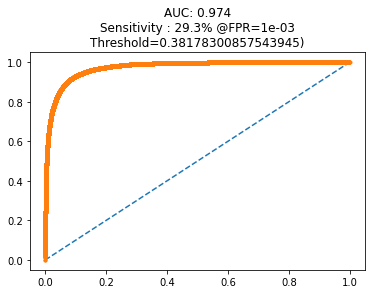

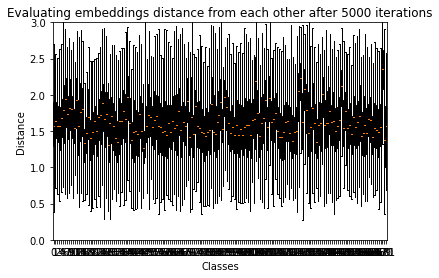

In [162]:
# Full evaluation
probs,yprob = compute_probs(network,x_test_origin,y_test_origin)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(network,n_iteration)

## 9. Save Model

In [163]:
# Save model
network.save('full_model_integration')

# Save Model to json
net_json = network.to_json()
with open("facial_recognition/trained_network.json", "w") as json_file:
    json_file.write(net_json)
# serialize weights to h5
network.save_weights("facial_recognition/trained_weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Load Model
from tensorflow import keras
model = keras.models.load_model('facial_recognition/trained_model')

# Load Model from json
from keras.models import model_from_json

# load json and create model
json_file = open('net.json', 'r')
loaded_net_json = json_file.read()
json_file.close()
loaded_net = model_from_json(loaded_net_json)
# load weights into new model
loaded_net.load_weights("network.h5")
print("Loaded model from disk")

Loaded model from disk


## 10. Benchmarking

#### Setup

In [164]:
### IMPORTS ###
from sklearn.metrics import f1_score, accuracy_score
import face_recognition as dlib_face_rec

In [165]:
### TEST DATA PREPARATION ###

# Data preparation OpenFace
x_benchmark_openface = x_test_origin
y_benchmark_openface = y_test_origin
print(x_benchmark_openface.shape, len(y_benchmark_openface))

# Data preparation Dlib
x_benchmark_dlib = x_test_origin * 255
x_benchmark_dlib = x_benchmark_dlib.astype('uint8')
y_benchmark_dlib = y_test_origin
print(x_benchmark_dlib.shape, len(y_benchmark_dlib))

(1304, 96, 96, 3) 1304
(1304, 96, 96, 3) 1304


In [166]:
### BENCHMARKING FUNCTIONS ###

# Euclidian distance
def distance(emb1, emb2):#
    return np.linalg.norm(emb1 - emb2)


def calc_distances(model_emb, labels):
    distances = [] 
    identical = [] # 1 if same identity, 0 otherwise

    num = len(labels)
    for i in range(num - 1):
        for j in range(i + 1, num):
            distances.append(distance(model_emb[i], model_emb[j]))
            identical.append(1 if labels[i] == labels[j] else 0)

    distances = np.array(distances)
    identical = np.array(identical)
    return distances, identical

def evaluate_performance(distances, identical, thresholds):
    f1_scores = [f1_score(identical, distances < t) for t in thresholds]
    acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

    opt_idx = np.argmax(f1_scores)
    # Threshold at maximal F1 score
    opt_tau = thresholds[opt_idx]
    # Accuracy at maximal F1 score
    opt_acc = accuracy_score(identical, distances < opt_tau)
    # Maximal F1 score
    opt_f1 = max(f1_scores)

    # Plot F1 score and accuracy as function of distance threshold
    plt.plot(thresholds, f1_scores, label='F1 score');
    plt.plot(thresholds, acc_scores, label='Accuracy');
    plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
    plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
    plt.xlabel('Distance threshold')
    plt.legend()
    plt.show

    return opt_tau, opt_acc, opt_f1

#### Openface Pretrained

In [177]:
### LOAD MODEL ###
from facial_recognition.models.openface_model import model as pretrained_network
pretrained_network.load_weights('facial_recognition/models/openface_weights.h5')     # <--- Pretrained weights

In [178]:
### TIMING ###

time_a = time.time()
x_emb_openface_pretrained = pretrained_network.predict(x_benchmark_openface)
time_b = time.time()

openface_time = time_b - time_a
print(f'Openface pretrained time: {openface_time} to embed {x_emb_openface_pretrained.shape[0]} faces.', x_emb_openface_pretrained.shape)

Openface pretrained time: 0.6306562423706055 to embed 1304 faces. (1304, 128)


Optimal treshold: 0.75
Optimal f1-score: 0.5506522342492368
Accuracy at maximal F1 score: 0.9847543893516143


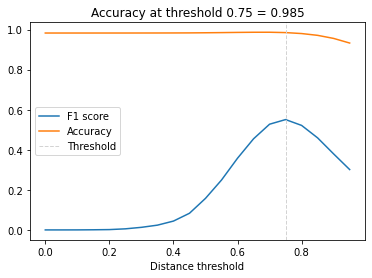

In [179]:
### BENCHMARKING ###

thresholds = np.arange(0.0, 1.0, 0.05)
distances, identical = calc_distances(x_emb_openface_pretrained, y_benchmark_openface)
opt_tau, opt_acc, opt_f1 = evaluate_performance(distances, identical, thresholds)

print('Optimal treshold:', opt_tau)
print('Optimal f1-score:', opt_f1)
print('Accuracy at maximal F1 score:', opt_acc)

#### Openface Trained

In [189]:
### TIMING ###

time_a = time.time()
x_emb_openface_trained = network.predict(x_benchmark_openface)
time_b = time.time()

openface_time = time_b - time_a
print(f'Openface time: {openface_time} to embed {x_emb_openface_trained.shape[0]} faces.', x_emb_openface_trained.shape)

Openface time: 0.6382434368133545 to embed 1304 faces. (1304, 128)


Optimal treshold: 0.75
Optimal f1-score: 0.5801373974521443
Accuracy at maximal F1 score: 0.9851804942817189


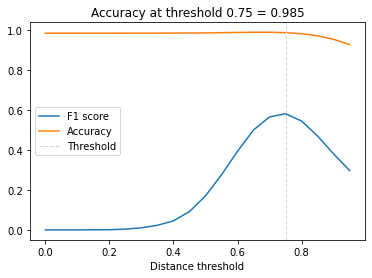

In [181]:
### BENCHMARKING ###

thresholds = np.arange(0.0, 1.0, 0.05)
distances, identical = calc_distances(x_emb_openface_trained, y_benchmark_openface)
opt_tau, opt_acc, opt_f1 = evaluate_performance(distances, identical, thresholds)

print('Optimal treshold:', opt_tau)
print('Optimal f1-score:', opt_f1)
print('Accuracy at maximal F1 score:', opt_acc)

#### Dlib

In [182]:
### TIMING ###

# Run model
time_a = time.time()
x_emb_dlib = np.array([dlib_face_rec.face_encodings(x, [(0,95,95,0)])[0] for x in x_benchmark_dlib])
time_b = time.time()

dlib_time = time_b - time_a
print(f'Dlib time: {dlib_time} to embed {x_emb_dlib.shape[0]} faces.', x_emb_dlib.shape)

Dlib time: 6.827467918395996 to embed 1304 faces. (1304, 128)


Optimal treshold: 0.49999999999999994
Optimal f1-score: 0.7031983730819006
Accuracy at maximal F1 score: 0.9905515351548339


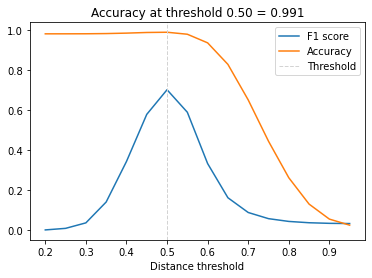

In [183]:
### BENCHMARKING ###

thresholds = np.arange(0.2, 1.0, 0.05)
distances, identical = calc_distances(x_emb_dlib, y_benchmark_dlib)
opt_tau, opt_acc, opt_f1 = evaluate_performance(distances, identical, thresholds)

print('Optimal treshold:', opt_tau)
print('Optimal f1-score:', opt_f1)
print('Accuracy at maximal F1 score:', opt_acc)